This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/legacy_datasets.ipynb)



# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [1]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [2]:
import math
import numpy as np
import pandas as pd

from typing import Optional, Callable, List
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from warnings import warn
from pathlib import Path

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [3]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Features

Here we prove that the feature extractor implemented (using a [Gammatone
Filterbank](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/gammatone/))
works as expected.


We will use the same audio file as in the [original
implementation](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/)
(A matlab C extension).


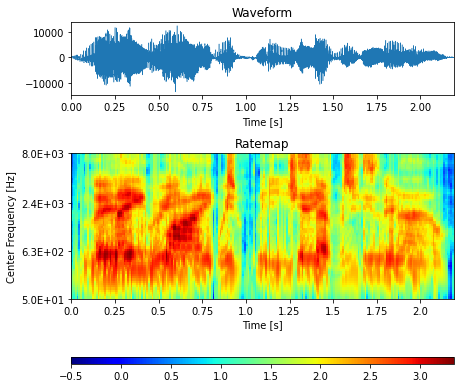

In [4]:
audio_url = (
    r"https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources"
    r"/ratemap/t29_lwwj2n_m17_lgwe7s.wav"
    )
data, sample_rate = ao.io.audio_read(audio_url)
frame_length = 10  # [ms]
frame_samples = int(
    np.ceil(frame_length / 1000 * sample_rate)
    )  # samples per frame
fig, axs = plt.subplots(
    3, 1, figsize=(6.5, 5.5), gridspec_kw={'height_ratios': [0.5, 1, 0.05]}
    )
# Signal
ao.plot.signal(data, sample_rate, ax=axs[0])
axs[0].set_title('Waveform')
# Gammatonegram
frame_length = 10  # [ms]
frame_samples = math.ceil(frame_length / 1000 * sample_rate)
plot, _ = ao.plot.gammatonegram(
    data,
    sample_rate,
    frame_samples,
    num_features=64,
    low_Hz=50,
    high_Hz=8000,
    pcolormesh_kwargs={
        'cmap': 'jet',
        'vmin': -0.5
        },
    ax=axs[1]
    )
axs[1].set_title('Ratemap')
fig.colorbar(plot, cax=axs[2], orientation="horizontal")
fig.tight_layout()

One can see that our implementation corresponds with the example found in the
original implementation.

![Ratemap](https://staffwww.dcs.shef.ac.uk/people/N.Ma/resources/ratemap/ratemap.png)


# Wheel Test Bed Experiments



## Experiment 0

Looks for `WHEELTESTBED_EXPERIMENT0` in the environment variables


In [5]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-0"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT0'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-12-37 from VAO_2022-03-08_17-12-37, item VAO_2022-03-08_17-12-37 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))
c:\Users\esdan\Desktop\AO\venv\lib\site-packages\ao\dataset\utils.py:159: UserWarning: Could not parse VAO_2022-03-08_17-11-21 from VAO_2022-03-08_17-11-21, item VAO_2022-03-08_17-11-21 should be composed by one `key` and one `value` separated by a unique underscore but 2 `_` were found.
  warn(str(e))


In [6]:
def plot_primitive_experiment(audio_file, ax=None):
    data, sample_rate = ao.io.wave_read(audio_file)
    frame_length = 500  # [ms]
    frame_samples = int(
        np.ceil(frame_length / 1000 * sample_rate)
        )  # samples per frame
    return ao.plot.gammatonegram(
        data,
        sample_rate,
        frame_samples,
        num_features=64,
        low_Hz=0,
        high_Hz=22050,
        pcolormesh_kwargs={
            'cmap': 'jet',
            'vmin': -1
            },
        ax=ax
        )

In [7]:
data = pd.DataFrame.from_dict(recordings, orient='index')

In [8]:
# w_data = {}
# for c in data.values():
#     w_data[c['w']] = w_data.get(c['w'], []) + [c]
# fig, axs = plt.subplots(
#     len(w_data), max([len(v) for v in w_data.values()]), figsize=(15, 10)
#     )
# row = -1
# last_w = None
# for folder, experiment in data.items():
#     if last_w != experiment['w']:
#         row += 1
#         col = 0
#     else:
#         col += 1
#     last_w = experiment['w']
#     plot, ax = plot_primitive_experiment(
#         folder / 'audio0crop.wav', ax=axs[row, col]
#         )
#     ax.set_title(
#         ', '.join(
#             f"{k}={experiment[k]} {naming[k].get('unit', '')}"
#             for k in naming.keys()
#             )
#         )
# fig.colorbar(plot, cax=axs[-1, -1])
# fig.tight_layout()

## Experiment 1

In this section we will take a closer look to the Wheel Test Bed Experiment
results. We will generate an image dataset with features extracted from the
audio in order to train a classifier.

The dataset should be `WHEELTESTBED_EXPERIMENT` in the environment variables


In [9]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment_0 = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment_0)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f"Invalid experiment folder {EXPERIMENT_FOLDER}")
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT1'
        )
DATA_FOLDER = EXPERIMENT_FOLDER / 'recordings'
recordings, naming = ao.dataset.utils.list_data(DATA_FOLDER)

In [10]:
def read_wheeltestbed_control(recording: Path) -> pd.DataFrame:
    df = pd.read_csv(recording.parent / (recording.name + '.csv'))
    # Remove the first row from the dataframe, the velocity there is useless
    df = df.iloc[1:, :]
    return df


def get_Vx(
    data: pd.DataFrame,
    start_timestamp: float,
    end_timestamp: float,
    ) -> float:
    df = data[(data['timestamp'] >= start_timestamp)
              & (data['timestamp'] <= end_timestamp)]
    if df.empty:
        return 0
    # Weighted average of the Vx values giving more importance to the most
    # recent
    return (df['Vx'] * df['ms']).sum() / df['ms'].sum()


def get_label(
    data: pd.DataFrame,
    start_timestamp: float,
    end_timestamp: float,
    ) -> str:
    Vx = get_Vx(data, start_timestamp, end_timestamp)
    return f'{round(Vx * 100):03d}'

In [11]:
# TODO plot control data with labels for some segments

# Datasets

In [18]:
def get_legacy_features(sample_name: str, label: str) -> np.ndarray:
    return np.load(
        DATASETS_FOLDER / 'numpy-arrays' / label / f"{sample_name}.npy"
        )


In [27]:
def generate_features_dataset(
    recordings: List[Path],  # [Path(G:\WTB\rec\w_5.0;s_0.0), ...]
    output_folder: Path,
    # TODO data_augmentation: List[Callable]
    segment_duration: int = 1200,  # [milliseconds]
    segment_overlap: int = 1000,  # [milliseconds]
    frame_features: int = 256,
    frame_duration: int = 10,  # [milliseconds]
    *,
    extractor: ao.extractor.Extractor = ao.extractor.GammatoneFilterbank,
    compression: Optional[Callable[[float], float]] = math.log10,
    **extractor_kwargs,
    ) -> Path:
    # Check input
    output_folder.mkdir(exist_ok=True, parents=True)
    if not output_folder.is_dir():
        raise TypeError(
            f"output_folder must be a directory, not {output_folder}"
            )
    if any(output_folder.iterdir()):
        raise TypeError(
            f"output_folder must be empty but {output_folder} isn't"
            )
    if compression:
        compression = np.vectorize(compression)
    extractors = {}
    # TODO save dataset generation data in yaml file inside output folder
    # Progress bars
    progress = {
        'recording':
            tqdm(total=len(recordings), desc='Recordings', unit='folders'),
        'file':
            tqdm(desc='microphone?', unit='files'),
        'segment':
            tqdm(desc='Segments', unit='segments'),
        }
    # Iterate over recording folders
    for recording in recordings:
        # Wheel test bed control data
        try:
            wtb_control = read_wheeltestbed_control(recording)
        except FileNotFoundError:
            warn(f"Skip: No control data found for recording {recording.name}")
        # Iterate over audio recordings
        wav_files = list(recording.glob('microphone*.wav'))
        progress['file'].reset(len(wav_files))
        for wav_file in wav_files:
            progress['file'].set_description(wav_file.name)
            # Read data
            wav_data, sample_rate = ao.io.audio_read(wav_file)
            # Load configuration
            config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
            assert sample_rate == config['samplerate']
            frame_samples = int(frame_duration * sample_rate / 1000)
            # Get corresponding extract function
            try:
                extract = extractors[sample_rate]
            except KeyError:
                extract = extractors[sample_rate] = extractor(
                    num_samples=frame_samples,
                    num_features=frame_features,
                    sample_rate=sample_rate,
                    transform=compression,
                    **extractor_kwargs
                    )
            # Process audio segments
            start = config['start_timestamp']
            segments = ao.dataset.audio.segment(
                wav_data, sample_rate, segment_duration, segment_overlap
                )
            progress['segment'].reset(total=len(segments))
            for segment in segments:
                end = start + segment_duration / 1000
                label = get_label(wtb_control, start, end)
                features = ao.dataset.audio.features(
                    segment, extractors=[extract]
                    )
                # TODO Use WebDataset with raw Vx, not labels
                sample_name = (
                    f"device_{wav_file.stem};{recording.name};"
                    f"start_{start:.2f};end_{end:.2f}"
                    )
                # assert np.isclose(
                #     get_legacy_features(sample_name, label)[np.newaxis, :, :],
                #     features
                #     ).all()
                _output_folder = output_folder / label
                _output_folder.mkdir(exist_ok=True)
                with open(_output_folder / f"{sample_name}.npy", 'wb') as f:
                    np.save(f, features)
                start = end - segment_overlap / 1000
                progress['segment'].update()
            progress['file'].update()
        progress['recording'].update()
    for pbar in progress.values():
        pbar.close()
    return output_folder

In [14]:
DATASETS_FOLDER = EXPERIMENT_FOLDER / 'datasets'

In [15]:
def remove_folder(folder: Path):
    for d in folder.iterdir():
        for f in d.iterdir():
            f.unlink()
        d.rmdir()

In [16]:
for new_folder, folder in zip((DATASETS_FOLDER / 'new-numpy-arrays').iterdir(),
                              (DATASETS_FOLDER / 'numpy-arrays').iterdir()):
    for new_array_file, array_file in zip(
        new_folder.iterdir(), folder.iterdir()
        ):
        new_array = np.load(new_array_file)
        array = np.load(array_file)
        np.testing.assert_equal(new_array, array[np.newaxis, :, :])
    print(f"{folder.name} is equal to {new_folder.name}")

AssertionError: 
Arrays are not equal

Mismatched elements: 30720 / 30720 (100%)
Max absolute difference: 6.37672306
Max relative difference: 6733.83514577
 x: array([[[-4.617809, -4.32529 , -4.481673, ..., -4.302909, -4.314855,
         -4.584983],
        [-4.609302, -4.30388 , -4.440579, ..., -4.286832, -4.30387 ,...
 y: array([[[0.735403, 0.774194, 0.473064, ..., 0.565622, 1.069093,
         1.213033],
        [0.741688, 0.78535 , 0.484034, ..., 0.571953, 1.076034,...

In [29]:
output_folder = DATASETS_FOLDER / 'new-2-numpy-arrays'
output_folder.mkdir(exist_ok=True, parents=True)
generate_features_dataset(recordings.keys(), output_folder)

Recordings:   0%|          | 0/87 [00:00<?, ?folders/s]

microphone?: 0files [00:00, ?files/s]

Segments: 0segments [00:00, ?segments/s]

WindowsPath('G:/Shared drives/VAO/VAO_WheelTestBed-Experiment-1/datasets/new-2-numpy-arrays')